In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pylab import rcParams
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from IPython.core.display import HTML
from sklearn.preprocessing import StandardScaler
from plotly.offline import init_notebook_mode, iplot
import numpy as np
from PIL import Image
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from IPython.core.display import HTML
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from plotly.offline import init_notebook_mode, iplot
from PIL import Image

In [2]:
def Distance(x_actual, y_actual, x_predicted, y_predicted):#Euclidean Distance
    d_x = x_actual - x_predicted
    d_y = y_actual - y_predicted
    dist = d_x**2 + d_y**2
    dist = np.sqrt(dist)
    #dist = np.sort(dist)
    return dist
def CDF_pic(distances,method):
    sorted_dist = np.sort(distances)
    mean_dist = np.mean(distances)
    probabilites = 1. * np.arange(len(sorted_dist))/(len(sorted_dist) - 1)
    fig, ax = plt.subplots()
    ax.plot(sorted_dist, probabilites, color='black')
    plt.title('CDF of Euclidean distance error by: '+ method)
    plt.xlabel('Distance (m)')
    plt.ylabel('Probability')
    plt.text(4,0,f"Mean Error.: {mean_dist}")
    plt.grid(True)
    plt.show()
    plt.close()
def scores(y_test_k,pred_test_k):
    distances_true =Distance(0, 0,y_test_k["x"], y_test_k["y"])
    distances_pred =Distance(pred_test_k[:, 0], pred_test_k[:, 1],0, 0)
    dis_true = np.array(distances_true)
    r2score = r2_score(dis_true, distances_pred)
    score = explained_variance_score(dis_true, distances_pred)
    print("Explained variance score is: ", score.round(4))
    print("R^2 score is: ",r2score.round(4))
def iplot_pic(y_test,pred_test):
    image = Image.open("iBeacon_Layout.jpg")
    init_notebook_mode(connected=True)

    xm=np.min(y_test ["x"])-1.5
    xM=np.max(y_test ["x"])+1.5
    ym=np.min(y_test ["y"])-1.5
    yM=np.max(y_test ["y"])+1.5

    data=[dict(x=[0], y=[0], 
               mode="markers", name = "Predictions",
               line=dict(width=2, color='green')
              ),
          dict(x=[0], y=[0], 
               mode="markers", name = "Actual",
               line=dict(width=2, color='blue')
              )

        ]

    layout=dict(xaxis=dict(range=[xm, 24], autorange=False, zeroline=False),
                yaxis=dict(range=[ym, 21], autorange=False, zeroline=False),
                title='Moving Dots', hovermode='closest',
                images= [dict(
                      source= image,
                      xref= "x",
                      yref= "y",
                      x= -3.5,
                      y= 22,
                      sizex= 36,
                      sizey=25,
                      sizing= "stretch",
                      opacity= 0.5,
                      layer= "below")]
                )

    frames=[dict(data=[dict(x=[pred_test[k, 0]], 
                            y=[pred_test[k, 1]], 
                            mode='markers',

                            marker=dict(color='red', size=10)
                            ),
                       dict(x=[y_test["x"].iloc[k]], 
                            y=[y_test["y"].iloc[k]], 
                            mode='markers',

                            marker=dict(color='blue', size=10)
                            )
                      ]) for k in range(int(len(pred_test))) 
           ]    

    figure1=dict(data=data, layout=layout, frames=frames)          
    iplot(figure1)

In [3]:
data = pd.read_csv(r"iBeaconData_org.csv")
beaconData = data
ibeaconMarks = beaconData.iloc[:,-2:]#y
ibeaconRSSI= beaconData.iloc[:,1:-2]#x
#ibeaconDis = Distance(ibeaconMarks["x"], ibeaconMarks["y"], 0, 0)
#ibeaconDis = pd.DataFrame(ibeaconDis*10000,columns = ["dis"],dtype=int).round(2)## svm only accept int type not floating point

Explained variance score is:  0.8215
R^2 score is:  0.8211


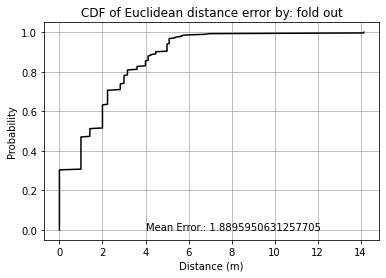

In [4]:

X_train, X_test,y_train,y_test= train_test_split(ibeaconRSSI,ibeaconMarks,test_size=0.2, random_state=2018, shuffle=True)
scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)
xgb_model = MultiOutputRegressor(XGBClassifier(max_depth=3, learning_rate =0.3))
xgb_model.fit(X_train, y_train)
pred_test = xgb_model.predict(X_test)
pred = Distance(0, 0,pred_test[:, 0], pred_test[:, 1])
distances =Distance(y_test["x"], y_test["y"],pred_test[:, 0], pred_test[:, 1])
method = "fold out"
scores(y_test,pred_test)
CDF_pic(distances,method)


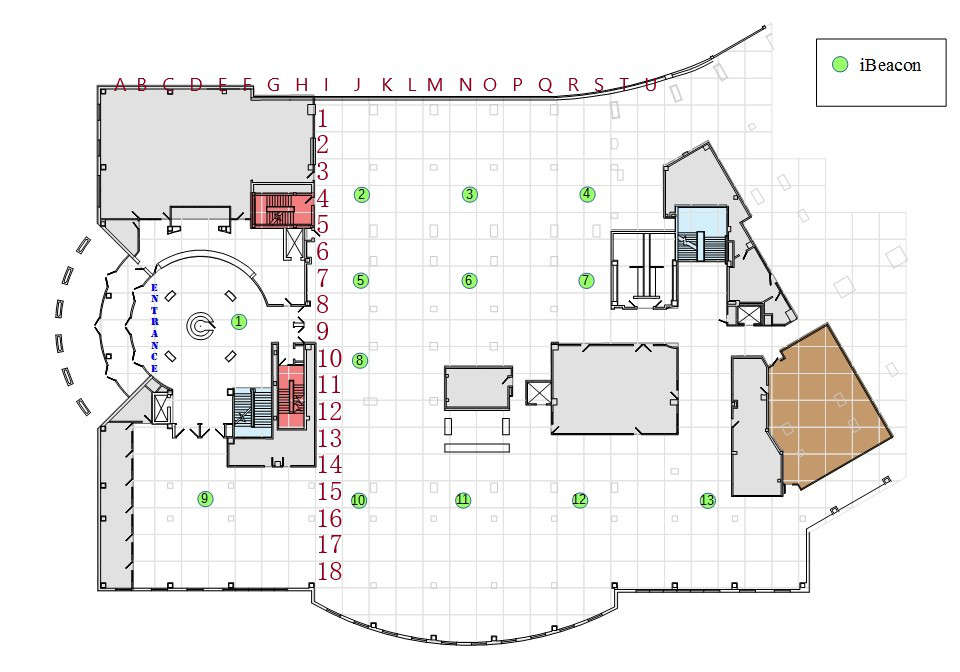

In [5]:
iplot_pic(y_test,pred_test)

Explained variance score is:  0.8577
R^2 score is:  0.8573


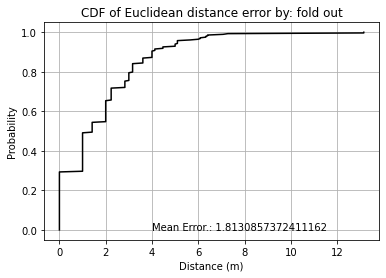

Explained variance score is:  0.8994
R^2 score is:  0.8982


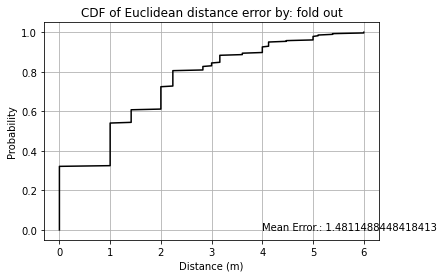

Explained variance score is:  0.8839
R^2 score is:  0.8839


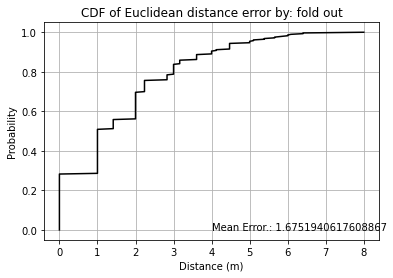

Explained variance score is:  0.8208
R^2 score is:  0.8205


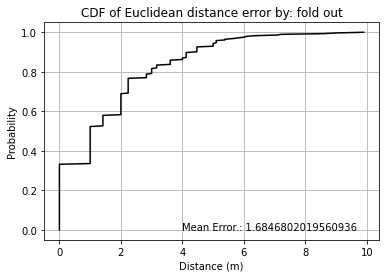

Explained variance score is:  0.8024
R^2 score is:  0.7971


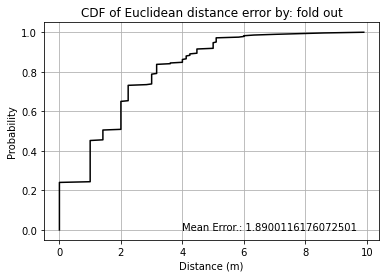

In [6]:
kf = KFold(n_splits=5, shuffle= True, random_state=35)
for train_index, test_index in kf.split(ibeaconRSSI,ibeaconMarks):
    X_train, X_test, y_train, y_test = ibeaconRSSI.iloc[train_index], ibeaconRSSI.iloc[test_index], ibeaconMarks.iloc[train_index], ibeaconMarks.iloc[test_index]
    scaler = StandardScaler()  
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)  
    X_test = scaler.transform(X_test)
    xgb_model = MultiOutputRegressor(XGBClassifier(max_depth=3, learning_rate =0.3))
    xgb_model.fit(X_train, y_train)
    pred_test = xgb_model.predict(X_test)
    pred = Distance(0, 0,pred_test[:, 0], pred_test[:, 1])
    distances =Distance(y_test["x"], y_test["y"],pred_test[:, 0], pred_test[:, 1])
    method = "fold out"
    scores(y_test,pred_test)
    CDF_pic(distances,method)


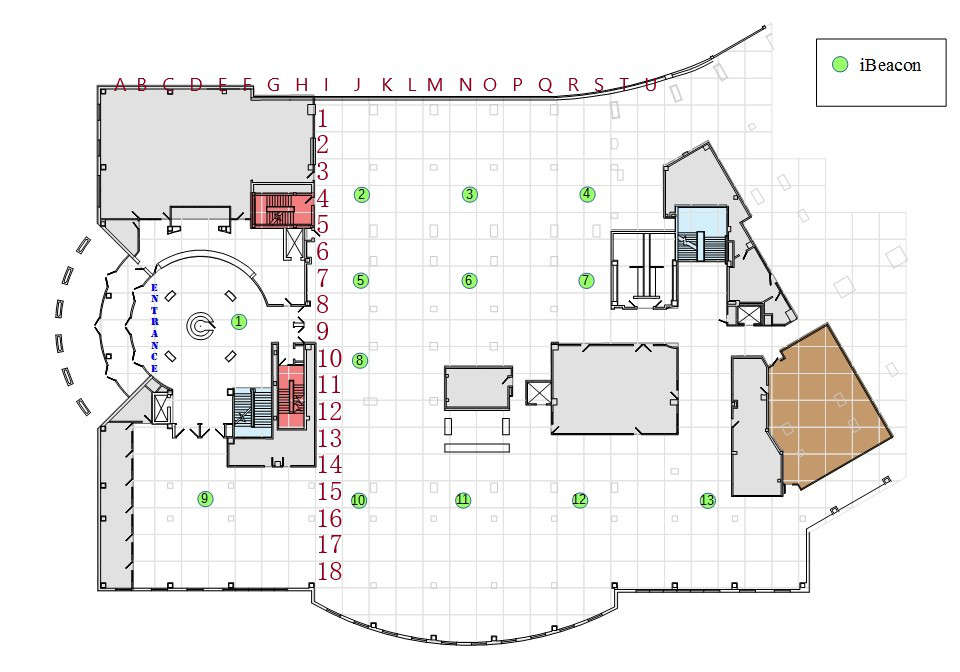

In [7]:
iplot_pic(y_test,pred_test)